In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kstest, kruskal

df = pd.read_excel("12_Nebraska_Tractor_Tests_data.xlsx")
display(df.shape)
display(df.info())
display(df.describe())

(3846, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3846 entries, 0 to 3845
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       3846 non-null   int64  
 1   Pdf Link                 3846 non-null   object 
 2   Year                     3846 non-null   int64  
 3   Nebraska Test Number     2891 non-null   object 
 4   Nebraska Summary Number  1613 non-null   object 
 5   Manufacturer             3804 non-null   object 
 6   Make                     3846 non-null   object 
 7   Model                    3804 non-null   object 
 8   Transmission             3804 non-null   object 
 9   Chassis                  3804 non-null   object 
 10  Fuel                     3804 non-null   object 
 11  PTO HP                   2953 non-null   float64
 12  Belt HP                  752 non-null    float64
 13  Drawbar HP               3633 non-null   float64
 14  Remarks                 

None

,Id,Year,PTO HP,Belt HP,Drawbar HP
count,3846.000000,3846.000000,2953.000000,752.000000,3633.000000
mean,1923.500000,1981.868175,128.743312,40.240691,101.293614
std,1110.388896,26.641834,93.554361,20.497846,88.677504
min,1.000000,1920.000000,11.000000,1.000000,0.600000
25%,962.250000,1962.000000,63.000000,27.000000,41.000000
50%,1923.500000,1984.000000,99.000000,36.000000,71.000000
75%,2884.750000,2005.000000,164.000000,49.000000,131.000000
max,3846.000000,2022.000000,598.000000,145.000000,531.000000


## 1. Is drawbar horsepower associated with tractor specifications?

- Response variables: Drawbar HP
- Explanatory variables: Year, Transmission, Chassis, Fuel, PTO HP, Belt HP

### Trend of Average Drawbar HP (Yearly)

Variables: Year, Drawbar HP

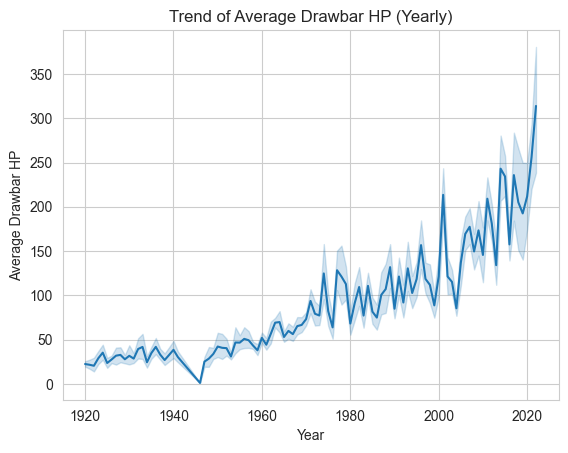

In [2]:
sns.lineplot(data=df, x='Year', y='Drawbar HP')
plt.title('Trend of Average Drawbar HP (Yearly)')
plt.xlabel('Year')
plt.ylabel('Average Drawbar HP')
plt.show()

### Drawbar HP by Transmission, Chassis, and Fuel

Variables: Transmission, Chassis, Fuel, Drawbar HP

In [3]:
print(f'Number of transmission types: {df["Transmission"].nunique()}')
print(f'Number of chassis types: {df["Chassis"].nunique()}')
print(f'Number of fuel types: {df["Fuel"].nunique()}')

Number of transmission types: 17
Number of chassis types: 9
Number of fuel types: 6


In [4]:
df['Fuel'].unique()

array(['K', nan, 'G', 'DIST', 'D', 'TF', 'LPG'], dtype=object)

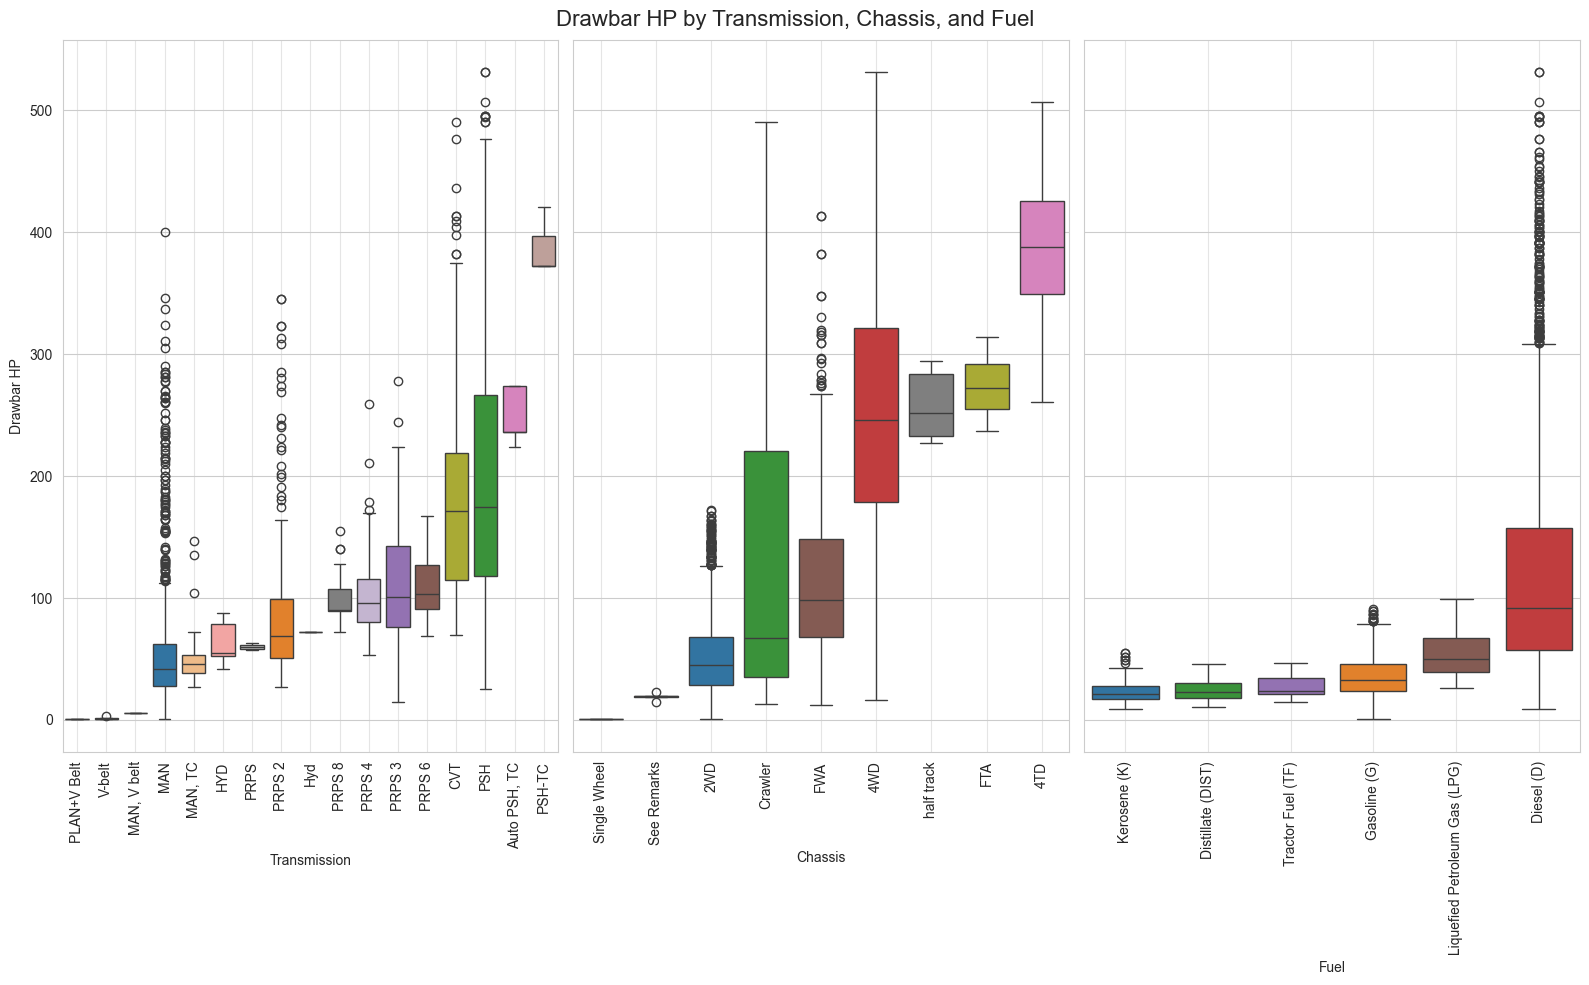

In [5]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=True,
    figsize=(16, 10)
)

# axs[0]
transmission_order = df.groupby('Transmission')['Drawbar HP'].median().sort_values().index
sns.boxplot(data=df, x='Transmission', y='Drawbar HP', hue='Transmission', legend=False, palette='tab20', ax=axs[0], order=transmission_order)
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(axis='x', linestyle='-', alpha=0.5)

# axs[1]
chassis_order = df.groupby('Chassis')['Drawbar HP'].median().sort_values().index
sns.boxplot(data=df, x='Chassis', y='Drawbar HP', hue='Chassis', legend=False, ax=axs[1], palette='tab10', order=chassis_order)  # palette='tab20c', 
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(axis='x', linestyle='-', alpha=0.5)

# axs[2]
fuel_order = df.groupby('Fuel')['Drawbar HP'].median().sort_values().index
# According to an introduce from Team Tractor Ranch Company (https://www.teamtractor.com)
custom_fuel_label_map = {
    'K': 'Kerosene (K)',
    'G': 'Gasoline (G)',
    'DIST': 'Distillate (DIST)',
    'D': 'Diesel (D)',
    'TF': 'Tractor Fuel (TF)',
    'LPG': 'Liquefied Petroleum Gas (LPG)'
}
custom_fuel_label = [custom_fuel_label_map[fuel] for fuel in fuel_order]
sns.boxplot(data=df, x='Fuel', y='Drawbar HP', hue='Fuel', legend=False, ax=axs[2], order=fuel_order)  # palette='RdBu', 
axs[2].set_xticks(range(len(fuel_order)))
axs[2].set_xticklabels(custom_fuel_label, rotation=90)
axs[2].grid(axis='x', linestyle='-', alpha=0.5)

fig.suptitle('Drawbar HP by Transmission, Chassis, and Fuel', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [6]:
# Check the "Remarks" field when the "Chassis" value is "See Remarks".
df[df['Chassis'] == 'See Remarks']['Remarks']

5            3 wheel, 1 drive wheel
21        Rear-drum, front-2 wheels
62    2 front wheels, 2 rear tracks
71    2 front wheels, 2 rear tracks
95               2 wheels, 2 tracks
Name: Remarks, dtype: object

### Drawbar HP with Belt HP and PTO HP

Variables: Belt HP, PTO HP, Drawbar HP

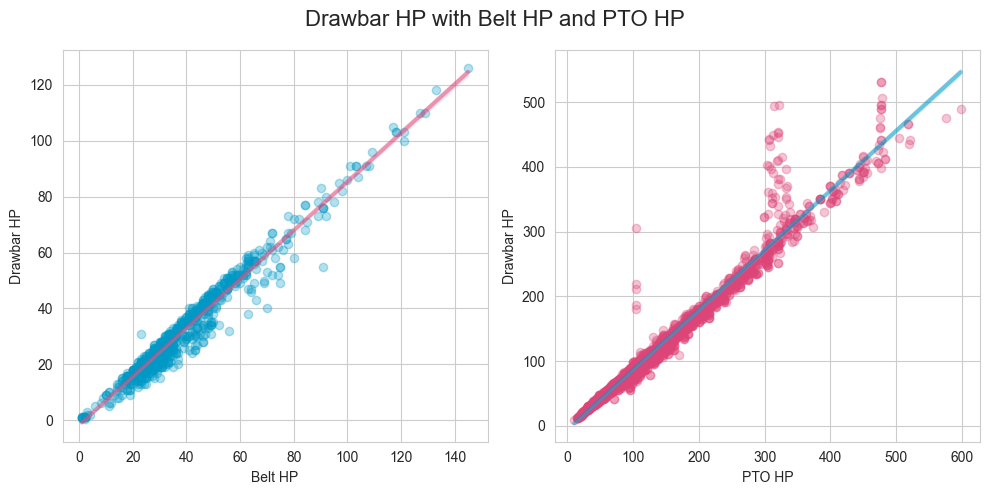

In [7]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=False,
    figsize=(10, 5)
)

# axs[0]
sns.regplot(
    data=df,
    x='Belt HP',
    y='Drawbar HP',
    ax=axs[0],
    scatter_kws={'alpha':0.3, 'color': '#0099C6'},
    line_kws={'alpha':0.5, 'color':'#DD4477', 'linewidth':3}
)

# axs[1]
sns.regplot(
    data=df,
    x='PTO HP',
    y='Drawbar HP',
    ax=axs[1],
    scatter_kws={'alpha':0.3, 'color': '#DD4477'},
    line_kws={'alpha':0.5, 'color':'#0099C6', 'linewidth':3}
)

fig.suptitle('Drawbar HP with Belt HP and PTO HP', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 2. Do Manufacturers Differ in PTO Adoption Year?

- Response variables: Year
- Explanatory variables: Manufacturer

In [8]:
print(f'Number of manufacturer: {df["Manufacturer"].nunique()}')

Number of manufacturer: 192


### Number of Tractors with Belt HP vs PTO HP Over Time

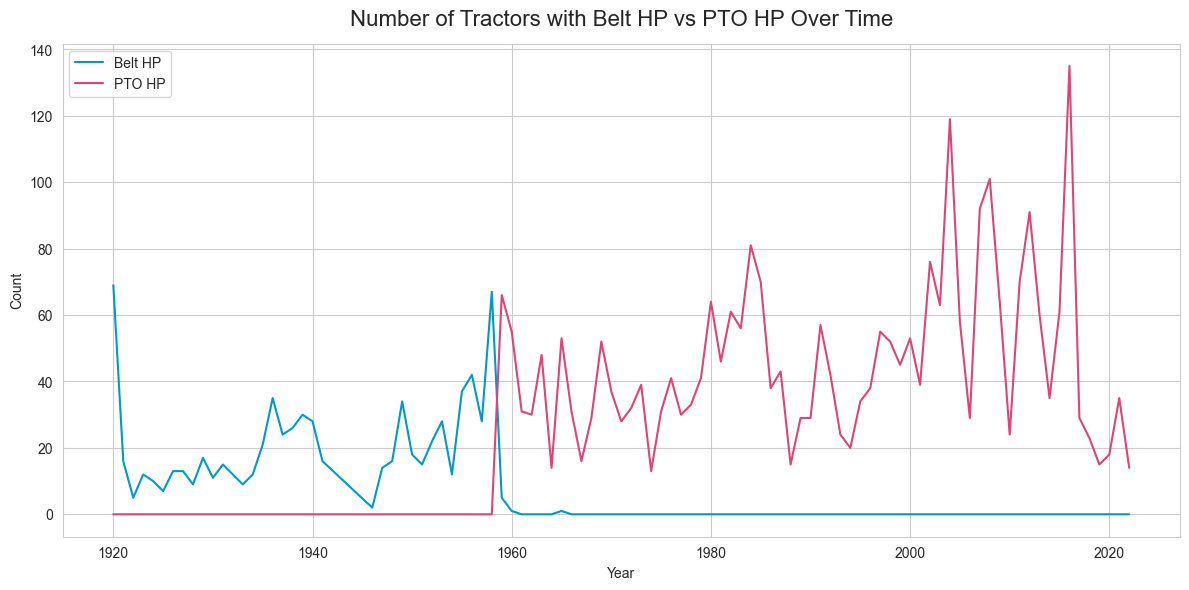

In [9]:
yearly_counts = df.groupby('Year')[['Belt HP', 'PTO HP']].count()
yearly_counts.plot(figsize=(12, 6), kind='line', color=['#0099C6', '#DD4477'])

plt.title('Number of Tractors with Belt HP vs PTO HP Over Time', fontsize=16, y=1.02)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(yearly_counts.columns, loc='upper left')
plt.tight_layout()
plt.show()

### Transition Years from Belt to PTO by Manufacturer

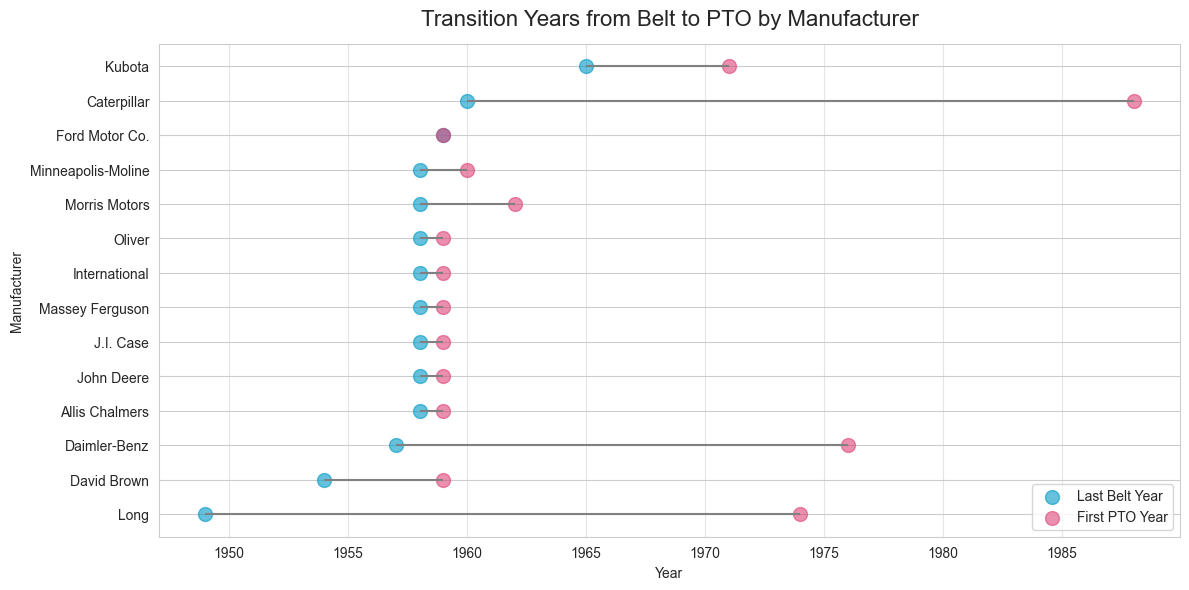

In [10]:
belt_years = df[df['Belt HP'].notna()].groupby('Manufacturer')['Year'].max().reset_index()
belt_years.columns = ['Manufacturer', 'Last_Belt_Year']

pto_years = df[df['PTO HP'].notna()].groupby('Manufacturer')['Year'].min().reset_index()
pto_years.columns = ['Manufacturer', 'First_PTO_Year']

transition_df = pd.merge(belt_years, pto_years, on='Manufacturer')

melted = transition_df.melt(
    id_vars='Manufacturer',
    value_vars=['Last_Belt_Year', 'First_PTO_Year'],
    var_name='Transition Type',
    value_name='Year'
)

transition_df_sorted = transition_df.sort_values('Last_Belt_Year')

plt.figure(figsize=(12, 6))

first = True
for _, row in transition_df_sorted.iterrows():
    m = row['Manufacturer']
    y_belt = row['Last_Belt_Year']
    y_pto = row['First_PTO_Year']
    plt.hlines(y=m, xmin=y_belt, xmax=y_pto, color='gray')
    if first:
        plt.scatter(y_belt, m, color='#0099C6', s=100, alpha=0.6, label='Last Belt Year')
        plt.scatter(y_pto,  m, color='#DD4477', s=100, alpha=0.6, label='First PTO Year')
        first = False
    else:
        plt.scatter(y_belt, m, color='#0099C6', s=100, alpha=0.6)
        plt.scatter(y_pto,  m, color='#DD4477', s=100, alpha=0.6)


plt.title('Transition Years from Belt to PTO by Manufacturer', fontsize=16, y=1.02)
plt.xlabel('Year')
plt.ylabel('Manufacturer')
plt.grid(axis='x', linestyle='-', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 3. Is the Use of Diesel Fuel Increasing Over Time?

- Response variables: Diesel_Used
- Explanatory variables: Year

In [11]:
print(f'Year min: {df["Year"].min()}')
print(f'Year max: {df["Year"].max()}')
print(f'Number of fuel type: {df["Fuel"].nunique()}')

fuel_map = {
    'K': 'Kerosene (K)',
    'G': 'Gasoline (G)',
    'DIST': 'Distillate (DIST)',
    'D': 'Diesel (D)',
    'TF': 'Tractor Fuel (TF)',
    'LPG': 'Liquefied Petroleum Gas (LPG)'
}
df['Fuel_fullname'] = df['Fuel'].map(fuel_map)
print('Number of each fuel type:')
display(df["Fuel_fullname"].value_counts())

Year min: 1920
Year max: 2022
Number of fuel type: 6
Number of each fuel type:


Fuel_fullname
Diesel (D)                       2943
Gasoline (G)                      551
Kerosene (K)                      111
Liquefied Petroleum Gas (LPG)     103
Distillate (DIST)                  77
Tractor Fuel (TF)                  19
Name: count, dtype: int64

### Fuel Type Distribution Over Time (Grouped by 5 Years)

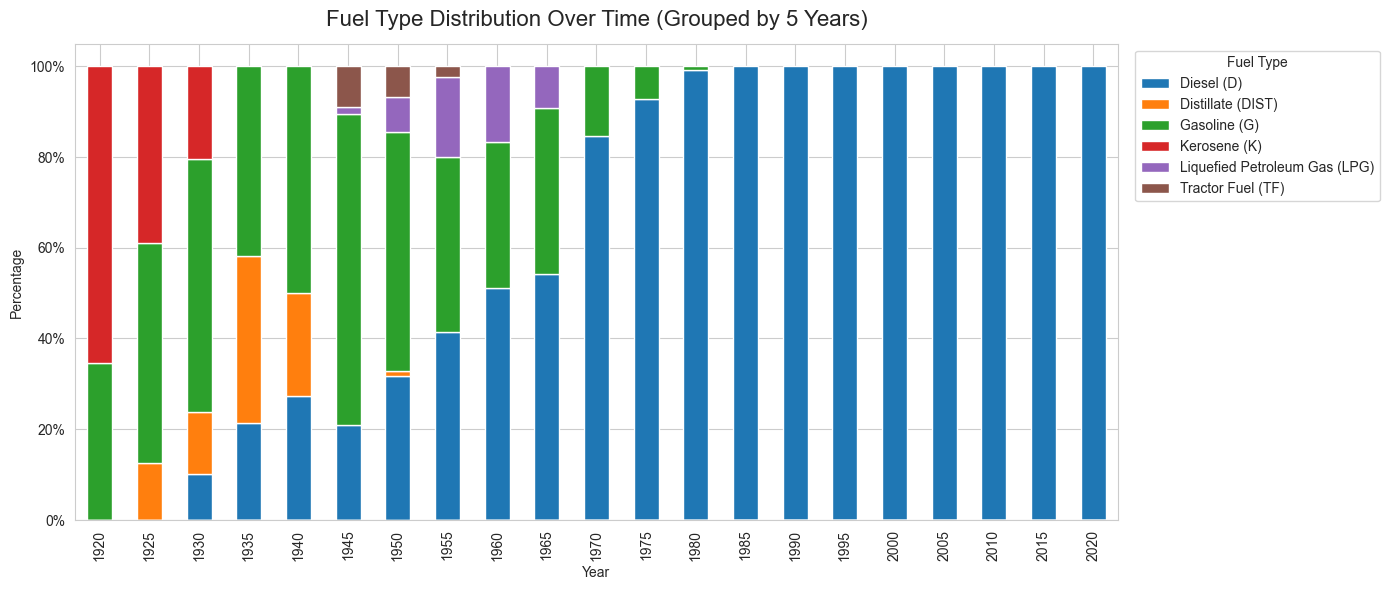

In [12]:
df['Year_group'] = (df['Year'] // 5) * 5

fuel_counts = df.groupby(['Year_group', 'Fuel_fullname']).size().unstack(fill_value=0)

fuel_percent = fuel_counts.div(fuel_counts.sum(axis=1), axis=0) * 100

fuel_percent.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Fuel Type Distribution Over Time (Grouped by 5 Years)', fontsize=16, y=1.02)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend(title='Fuel Type', bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.show()

# Statistical tests

## 1. Is drawbar horsepower associated with tractor specifications?

Hypothesis:
- H0: There is no statistically significant relationship between tractor specifications (year, transmission, chassis, fuel, belt horsepower, and PTO horsepower) and drawbar horsepower.
- H1: At least one of the tractor specifications (year, transmission, chassis, fuel, belt horsepower, or PTO horsepower) has a statistically significant effect on drawbar horsepower.

In [13]:
# Create DataFrame for first statistical test
df_first = df.loc[:, ['Year', 'Transmission', 'Chassis', 'Fuel_fullname', 'PTO HP', 'Belt HP', 'Drawbar HP']]
df_first.dropna(subset=['Drawbar HP'], inplace=True)
df_first['Is_PTO'] = df_first['PTO HP'].notna().astype(int)
df_first['HP_Value'] = df_first['PTO HP'].fillna(df_first['Belt HP'])
df_first.dropna(subset=['HP_Value'], inplace=True)
df_first.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, 0 to 3845
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           3534 non-null   int64  
 1   Transmission   3534 non-null   object 
 2   Chassis        3534 non-null   object 
 3   Fuel_fullname  3534 non-null   object 
 4   PTO HP         2785 non-null   float64
 5   Belt HP        749 non-null    float64
 6   Drawbar HP     3534 non-null   float64
 7   Is_PTO         3534 non-null   int64  
 8   HP_Value       3534 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 276.1+ KB


In [14]:
model = smf.ols(
    formula='Q("Drawbar HP") ~ Year + HP_Value + Is_PTO + C(Transmission) + C(Chassis) + C(Fuel_fullname)',
    data=df_first.dropna(subset=['Drawbar HP', 'HP_Value'])
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("Drawbar HP")   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     4741.
Date:                Wed, 25 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:30:51   Log-Likelihood:                -14191.
No. Observations:                3534   AIC:                         2.844e+04
Df Residuals:                    3503   BIC:                         2.864e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          -247.2791     45.601     -5.423      0.000    -336.686    -157.872
C(Transmission)[T.HYD]                                0.2471      2.940      0.084      0.933      -5.518       6.012
C(Transmission)[T.Hyd]                              -21.5206     13.593     -1.583      0.113     -48.171       5.130
C(Transmission)[T.MAN]                               12.3336      1.272      9.694      0.000       9.839      14.828
C(Transmission)[T.MAN, TC]                           11.9386      2.734      4.366      0.000       6.578      17.300
C(Transmission)[T.MAN, V belt]                       11.4003     13.561      0.841      0.401     -15.188      37.988
C(Transmission)[T.PLAN+V Belt]                       12.0890     13.560      0.892      0.373     -14.497      38.675
C(Transmission)[T.PRPS]                              12.4279      9.595      1.295      0.195      -6.384      31.240
C(Transmission)[T.PRPS 2]                            11.8777      1.312      9.056      0.000       9.306      14.449
C(Transmission)[T.PRPS 3]                             9.0706      1.723      5.264      0.000       5.692      12.449
C(Transmission)[T.PRPS 4]                            11.3650      1.403      8.098      0.000       8.613      14.117
C(Transmission)[T.PRPS 6]                             5.4422      1.722      3.160      0.002       2.066       8.818
C(Transmission)[T.PRPS 8]                             5.0779      2.867      1.771      0.077      -0.544      10.700
C(Transmission)[T.PSH]                               11.3822      1.063     10.707      0.000       9.298      13.466
C(Transmission)[T.V-belt]                            13.6135      4.730      2.878      0.004       4.340      22.887
C(Chassis)[T.4TD]                                    31.4895      2.851     11.044      0.000      25.899      37.080
C(Chassis)[T.4WD]                                    13.1878      1.226     10.757      0.000      10.784      15.591
C(Chassis)[T.Crawler]                                 3.3595      0.994      3.378      0.001       1.410       5.309
C(Chassis)[T.FTA]                                   -14.6206      6.826     -2.142      0.032     -28.004      -1.238
C(Chassis)[T.FWA]                                    -5.2830      0.729     -7.245      0.000      -6.713      -3.853
C(Chassis)[T.See Remarks]                             1.6555      6.074      0.273      0.785     -10.253      13.564
C(Chassis)[T.Single Wheel]                            0.5416     14.207      0.038      0.970     -27.313      28.396
C(Chassis)[T.half track]                            -22.9890      5.593     -4.111      0.000     -33.954     -12.024
C(Fuel_fullname

### Assumption Checks for Multiple Linear Regression

- Linear Relationship for numerical variables

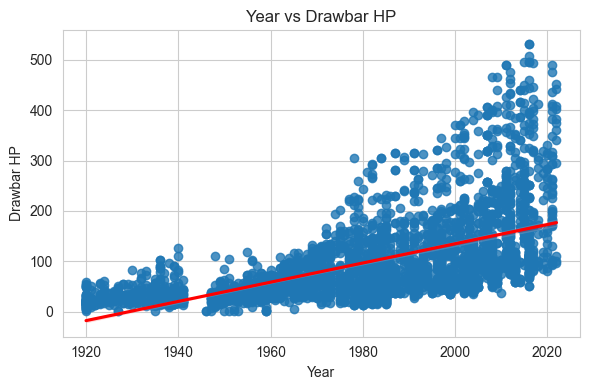

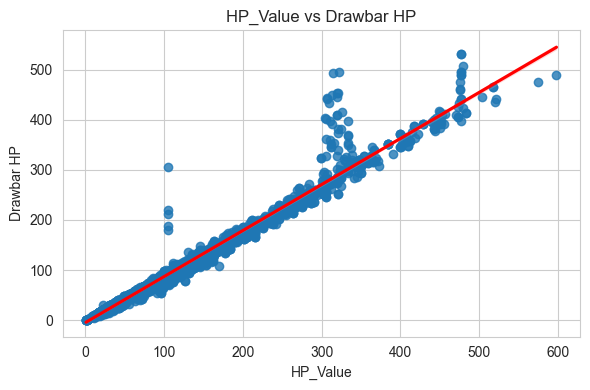

In [15]:
numeric_vars = ['Year', 'HP_Value']
for var in numeric_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=var, y='Drawbar HP', data=df_first, line_kws={'color': 'red'})
    plt.title(f'{var} vs Drawbar HP')
    plt.xlabel(var)
    plt.ylabel('Drawbar HP')
    plt.tight_layout()
    plt.show()

- Multivariate Normality

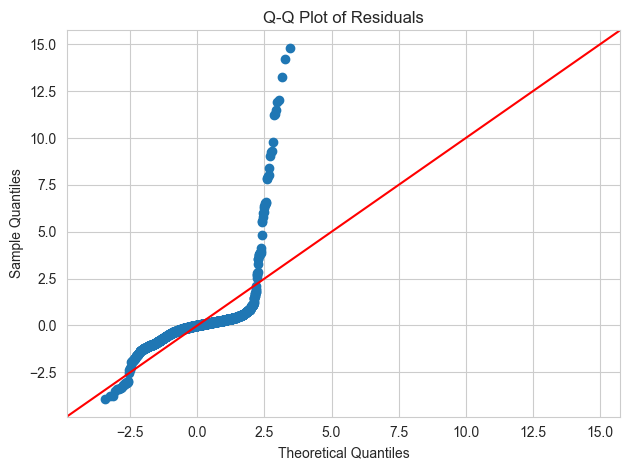

In [16]:
sm.qqplot(data=model.resid, fit=True, line='45')
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

In [17]:
standardized_residuals = (model.resid - model.resid.mean()) / model.resid.std()
ks_stat, ks_pval = kstest(standardized_residuals, 'norm')
print(f'Kolmogorov-Smirnov stat:{ks_stat}')
print(f'Kolmogorov-Smirnov p-value:{ks_pval}')

Kolmogorov-Smirnov stat:0.26409606815133313
Kolmogorov-Smirnov p-value:4.95070131739488e-218


- Multicollinearity

In [18]:
# Correlation matrix
numeric_vars = df_first[['Year', 'HP_Value']]
corr_matrix = numeric_vars.corr()
corr_matrix

,Year,HP_Value
Year,1.000000,0.610269
HP_Value,0.610269,1.000000


In [19]:
# Variance Inflation Factor (VIF)
X = sm.add_constant(numeric_vars)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,const,8639.344940
1,Year,1.593445
2,HP_Value,1.593445


- Homoscedasticity

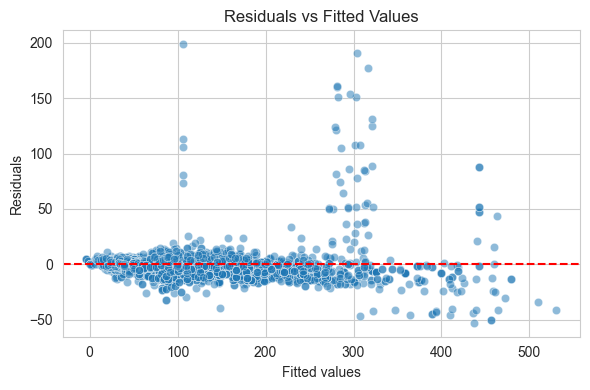

In [20]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=model.fittedvalues, y=model.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

## 2. Do Manufacturers Differ in PTO Adoption Year?

Hypothesis:
- H0: The average year of first PTO-equipped tractor introduction is the same across all manufacturers.
- H1: At least one manufacturer introduced PTO-equipped tractors significantly earlier or later than others.

In [21]:
df_second = df.loc[:, ['Year', 'Manufacturer', 'PTO HP']]
df_second.dropna(subset=['Year', 'Manufacturer', 'PTO HP'], inplace=True)
first_pto_years = df_second.groupby('Manufacturer')['Year'].min().reset_index()
groups = [group['Year'].values for name, group in first_pto_years.groupby('Manufacturer')]
group_sizes = first_pto_years.groupby('Manufacturer').size()

kruskal_stat, kruskal_pval = kruskal(*groups)
print(f'Kruskal-Wallis H statistic:{kruskal_stat:.4f}')
print(f'Kruskal-Wallis p-value:{kruskal_pval:.4f}')

Kruskal-Wallis H statistic:113.0000
Kruskal-Wallis p-value:0.4823


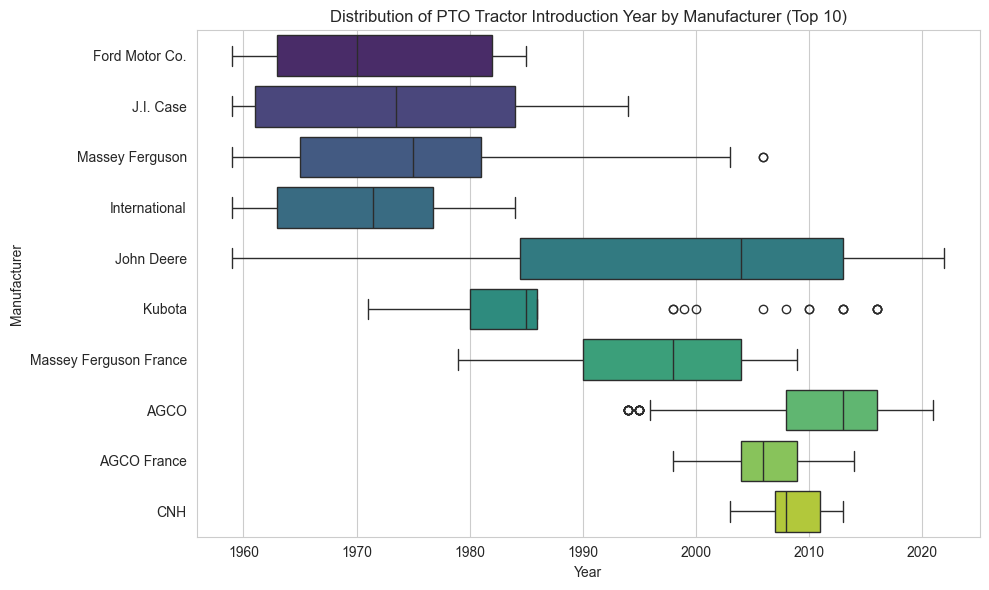

In [22]:
top_manufacturers = df_second['Manufacturer'].value_counts().nlargest(10).index
df_plot = df_second[df_second['Manufacturer'].isin(top_manufacturers)]

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_plot,
    x='Year',
    y='Manufacturer',
    hue='Manufacturer',
    palette='viridis'
)
plt.title('Distribution of PTO Tractor Introduction Year by Manufacturer (Top 10)')
plt.tight_layout()
plt.show()

### Assumption Checks for Kruskal-Wallis test

- Ordinal or continuous response variable

In [23]:
df_second['Year'].dtype

dtype('int64')

- The explanatory variable should be consist of two or more categorical, independent groups

In [24]:
display(df_second['Manufacturer'].nunique())
display(df_second['Manufacturer'].dtype)

114

dtype('O')

## 3. Is the Use of Diesel Fuel Increasing Over Time?

Hypothesis:
- H0: The average year of first PTO-equipped tractor introduction is the same across all manufacturers.
- H1: At least one manufacturer introduced PTO-equipped tractors significantly earlier or later than others.

In [25]:
df_third = df.loc[:, ['Year', 'Fuel']].dropna()
df_third['Is_Diesel'] = (df_third['Fuel'] == 'D').astype(int)
df_third.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3804 entries, 0 to 3845
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       3804 non-null   int64 
 1   Fuel       3804 non-null   object
 2   Is_Diesel  3804 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 118.9+ KB


In [26]:
model = smf.logit(formula='Is_Diesel ~ Year', data=df_third).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.224157
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Is_Diesel   No. Observations:                 3804
Model:                          Logit   Df Residuals:                     3802
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                  0.5809
Time:                        01:30:52   Log-Likelihood:                -852.69
converged:                       True   LL-Null:                       -2034.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -240.1529      9.135    -26.290      0.000    -258.057    -222.249
Year           0.1226      0.005     26.350      0.000       0.113       0.132
==============================================================================
"""

### Assumption Checks for Logistic Regression

- Binary or Ordinal Dependent Variable

In [27]:
df_third['Is_Diesel'].value_counts()

Is_Diesel
1    2943
0     861
Name: count, dtype: int64

- Linearity of the log-odds

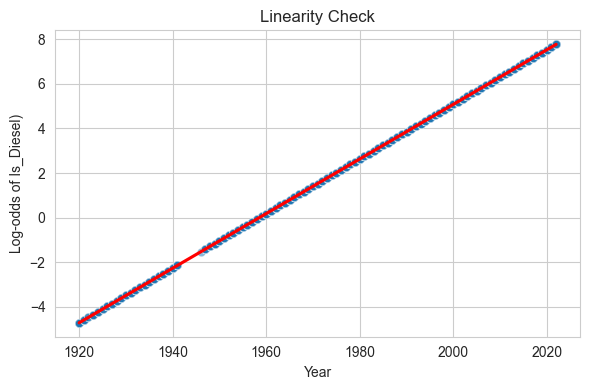

In [28]:
pred_probs = model.predict()
logit = np.log(pred_probs / (1 - pred_probs))

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_third['Year'], y=logit, alpha=0.3)
sns.regplot(x=df_third['Year'], y=logit, scatter=False, ci=None, color='red')
plt.xlabel('Year')
plt.ylabel('Log-odds of Is_Diesel)')
plt.title('Linearity Check')
plt.tight_layout()
plt.show()